In [49]:
from scipy.optimize import minimize, NonlinearConstraint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from PIL import Image,ImageFilter

In [50]:
data = pd.read_csv("full_big.csv")
data.columns =  [i for i in range(28*28+1)]
data = data[data.iloc[:, -1].isin(["A", "B", "C", "D", "E", "F", "G", "H", "I", "J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X", "Y", "Z"])]
groups = data.groupby(784)
myAlphas = pd.read_csv("myAlphas.csv")

In [51]:
train = pd.DataFrame()
test = pd.DataFrame()

alphas = data[784].unique()
alphas_combine = list(combinations(alphas, 2))

for label in alphas:
    data_ = groups.get_group(label)
    train = pd.concat([train, data_.iloc[:int(len(data_)/2), :]], ignore_index=True)
    test = pd.concat([test, data_.iloc[int(len(data_)/2):, :]], ignore_index=True)

In [53]:
#使用sklearn的SVM,非线性
clf = SVC(kernel="linear")
clf.fit(train.iloc[:, :-1], train.iloc[:, -1])
y_pred = clf.predict(test.iloc[:, :-1])
#使用skleran计算准确率
print("sklearn SVM准确率：", accuracy_score(test.iloc[:, -1], y_pred))

sklearn SVM准确率： 0.9023383768913342


In [54]:
def match_2(label1, label2):
    train_ = train[train.iloc[:, -1].isin([label1, label2])]
    test_ = test[test.iloc[:, -1].isin([label1, label2])]

    x_train = train_.iloc[:, :-1].values
    y_train = np.where(train_.iloc[:, -1] == label1, 1, -1)

    def objective_function(w):
        return 0.5 * np.dot(w[:784], w[:784])

    # Use a single NonlinearConstraint for all samples
    def constraint(w):
        return np.array([y * (np.dot(w[:784], xi) + w[784]) for y, xi in zip(y_train, x_train)])

    constraints = [NonlinearConstraint(constraint, 1, np.inf)]

    initial_guess = np.zeros(x_train.shape[1] + 1)

    result = minimize(objective_function, initial_guess, method='SLSQP', constraints=constraints)
    return result

In [56]:
res = pd.DataFrame(columns=alphas)
res["true"] = test.iloc[:, -1].values
for label in alphas:
    res[label] = 0
SVMS = []

count = 0

for labels in alphas_combine:
    label1 = labels[0]
    label2 = labels[1]

    count = count + 1

    print("正在构建第",count,"个SVM",label1,"和",label2,"的SVM")

    res_ = match_2(label1, label2)
    SVMS.append(res_)
    x = test.iloc[:, :-1].values
    y_pred = np.where(np.dot(x, res_.x[:784]) + res_.x[784] > 0, 1, -1)
    #若判定为label1，res中对应位置+1
    res[label1] = res[label1] + np.where(y_pred == 1, 1, 0)
    res[label2] = res[label2] + np.where(y_pred == -1, 1, 0)

正在构建第 1 个SVM A 和 B 的SVM
正在构建第 2 个SVM A 和 C 的SVM
正在构建第 3 个SVM A 和 D 的SVM
正在构建第 4 个SVM A 和 E 的SVM
正在构建第 5 个SVM A 和 F 的SVM
正在构建第 6 个SVM A 和 G 的SVM
正在构建第 7 个SVM A 和 H 的SVM
正在构建第 8 个SVM A 和 I 的SVM
正在构建第 9 个SVM A 和 J 的SVM
正在构建第 10 个SVM A 和 K 的SVM
正在构建第 11 个SVM A 和 L 的SVM
正在构建第 12 个SVM A 和 M 的SVM
正在构建第 13 个SVM A 和 N 的SVM
正在构建第 14 个SVM A 和 O 的SVM
正在构建第 15 个SVM A 和 P 的SVM
正在构建第 16 个SVM A 和 Q 的SVM
正在构建第 17 个SVM A 和 R 的SVM
正在构建第 18 个SVM A 和 S 的SVM
正在构建第 19 个SVM A 和 T 的SVM
正在构建第 20 个SVM A 和 U 的SVM
正在构建第 21 个SVM A 和 V 的SVM
正在构建第 22 个SVM A 和 W 的SVM
正在构建第 23 个SVM A 和 X 的SVM
正在构建第 24 个SVM A 和 Y 的SVM
正在构建第 25 个SVM A 和 Z 的SVM
正在构建第 26 个SVM B 和 C 的SVM
正在构建第 27 个SVM B 和 D 的SVM
正在构建第 28 个SVM B 和 E 的SVM
正在构建第 29 个SVM B 和 F 的SVM
正在构建第 30 个SVM B 和 G 的SVM
正在构建第 31 个SVM B 和 H 的SVM
正在构建第 32 个SVM B 和 I 的SVM
正在构建第 33 个SVM B 和 J 的SVM
正在构建第 34 个SVM B 和 K 的SVM
正在构建第 35 个SVM B 和 L 的SVM
正在构建第 36 个SVM B 和 M 的SVM
正在构建第 37 个SVM B 和 N 的SVM
正在构建第 38 个SVM B 和 O 的SVM
正在构建第 39 个SVM B 和 P 的SVM
正在构建第 40 个SVM B 和 Q 的SVM
正在构建第 41 

In [57]:
#计算准确率
count = 0
res["guess"] = res.iloc[:, :-1].idxmax(axis=1)
for i in range(res.shape[0]):
    if res.iloc[i, -1] == res.iloc[i, -2]:
        count += 1
print(f"训练数据准确率为：{count/res.shape[0]}")

训练数据准确率为：0.8995873452544704


In [58]:
def apply(alpha):
    predict = pd.DataFrame(columns=alphas)
    predict["combines"] = alphas_combine
    for label in alphas:
        predict[label] = 0

    test_x = myAlphas[myAlphas["label"] == alpha].values[0][:-1]
    img_matrix = test_x.reshape(28, 28)
    img_matrix = img_matrix.astype(float)  # 将 object 类型转换为 float 类型
    test_x = test_x.reshape(1, -1)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_matrix, cmap='gray')
    y_pred = clf.predict(test_x)
    sk_pre = y_pred[0]
    plt.title("sklearn "+y_pred[0])
    for i in range(len(alphas_combine)):

        label1 = alphas_combine[i][0]
        label2 = alphas_combine[i][1]

        res_ = SVMS[i].x
        y_pred = np.where(np.dot(test_x, res_[:784]) + res_[784] > 0, 1, -1)
        if (y_pred == 1):
            predict.loc[i, label1] += 1
        else:
            predict.loc[i, label2] += 1
    result = {}
    for label in alphas:
        result[label] = 0
    for i in range(predict.shape[0]):
        result[predict.iloc[i, :-1].astype(float).idxmax(axis=0)] += 1
    pre = pd.DataFrame(result, index=[0])
    #以列名为x轴，值为y轴绘制柱状图
    plt.subplot(1, 2, 2)
    plt.bar(pre.columns, pre.iloc[0, :])
    #值最高的柱子颜色设置为红色
    plt.bar(pre.iloc[0, :].idxmax(axis=0), pre.iloc[0, :].max(), color="red")
    my_pred = pre.iloc[0, :].idxmax(axis=0)
    plt.title("me "+ pre.iloc[0, :].idxmax(axis=0))
    plt.xlabel("alphas")
    plt.ylabel("count")

    return sk_pre, my_pred

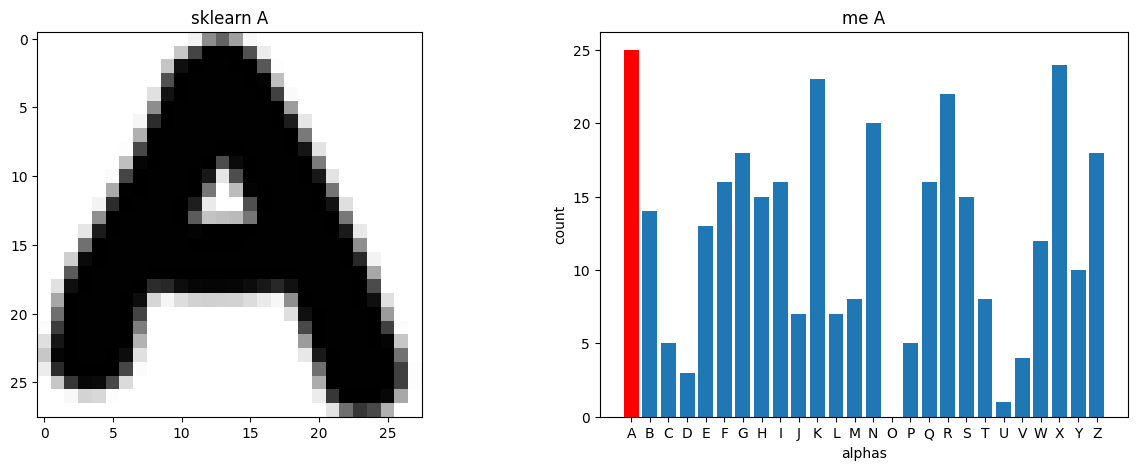

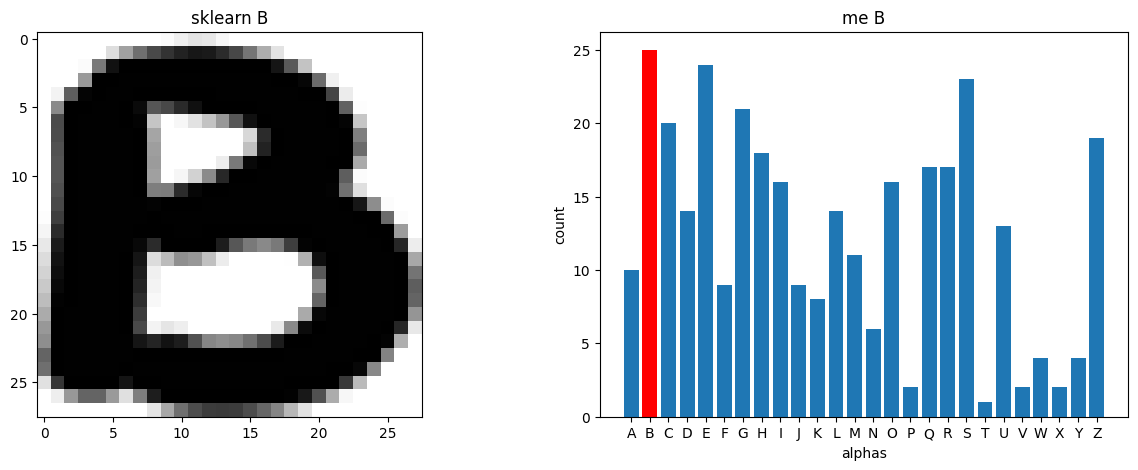

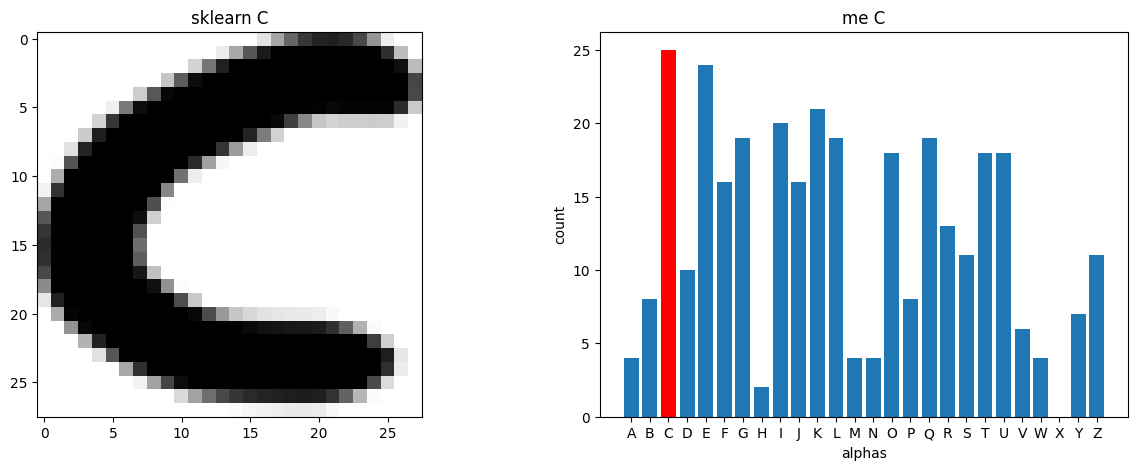

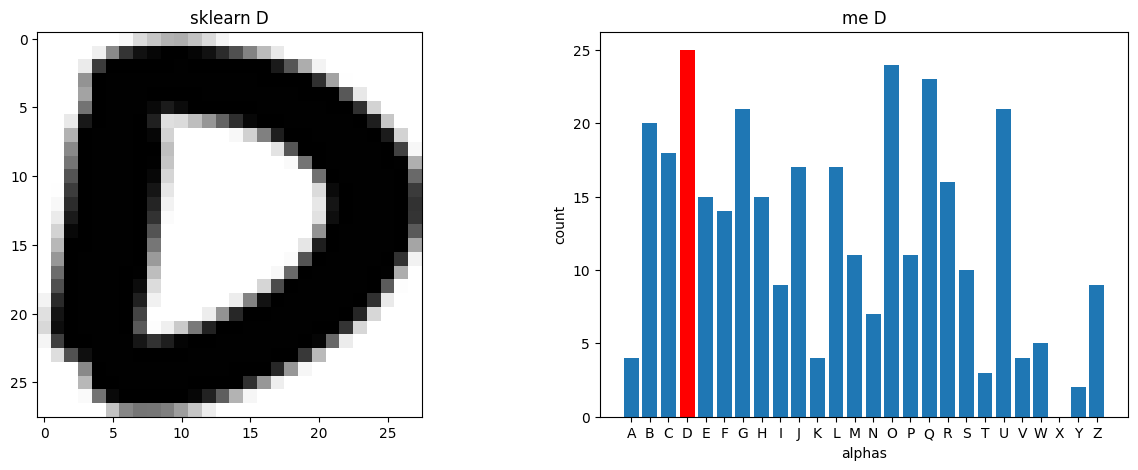

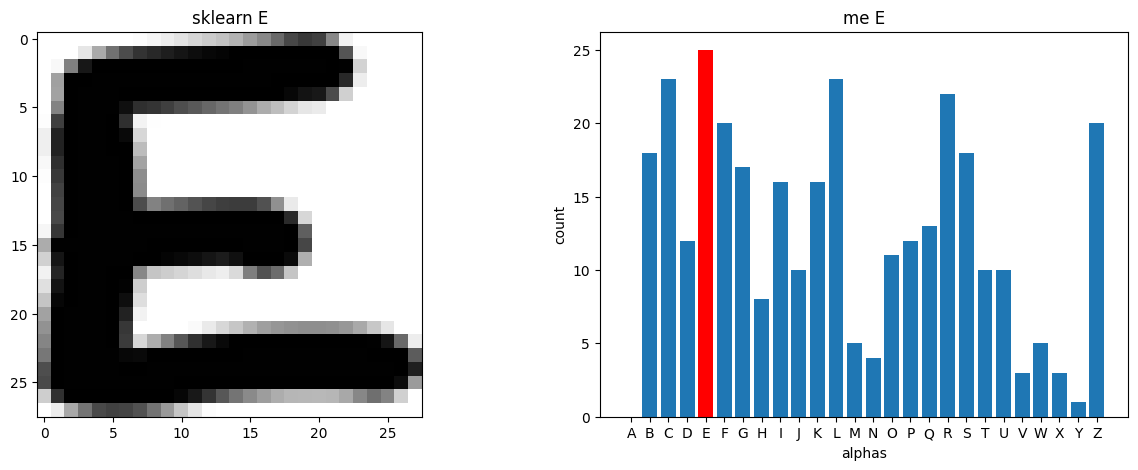

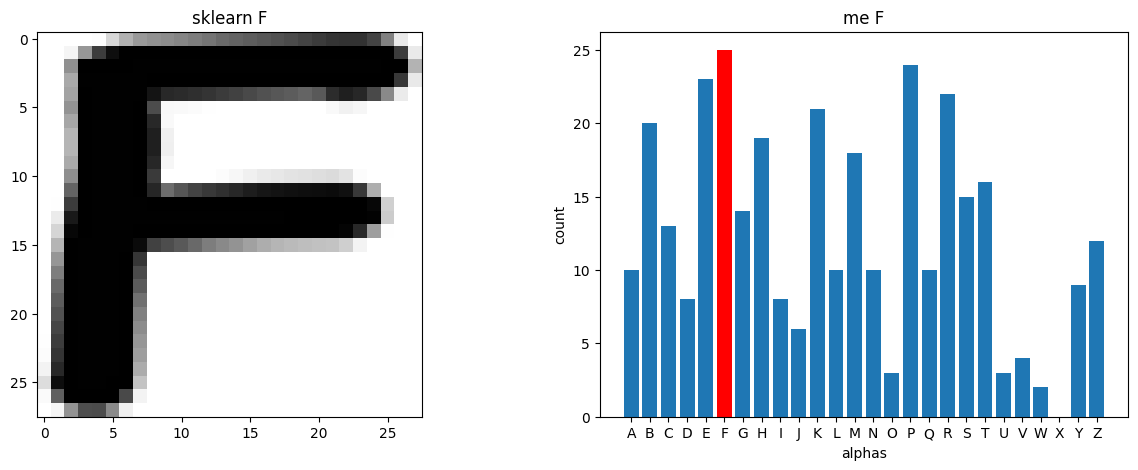

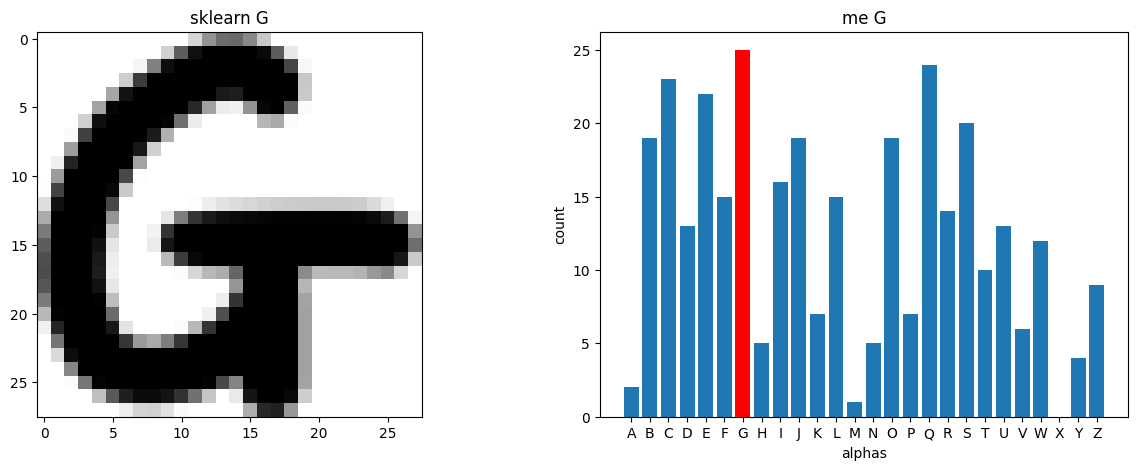

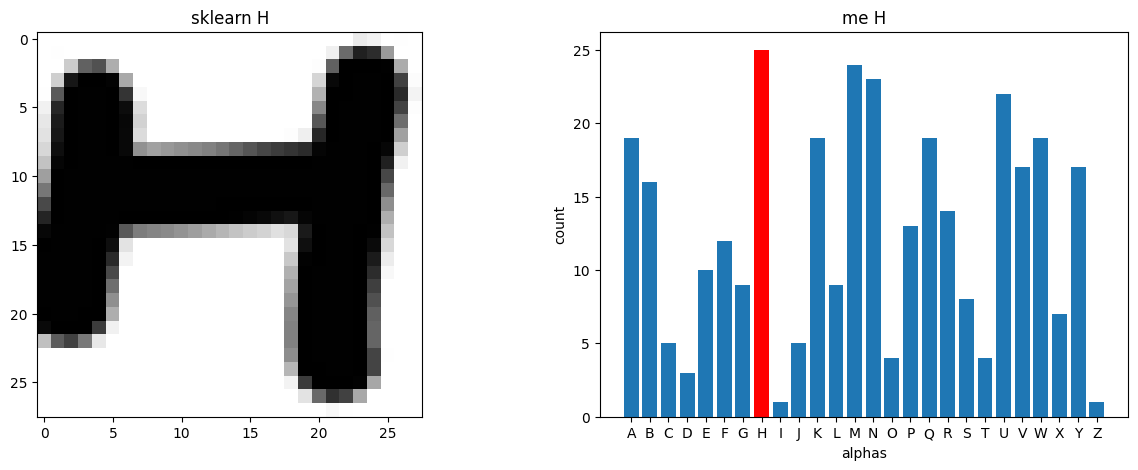

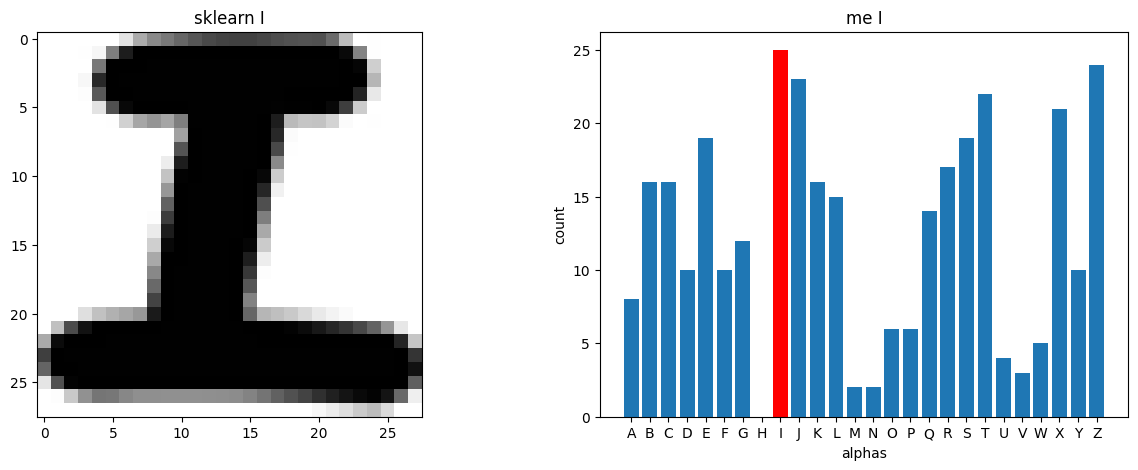

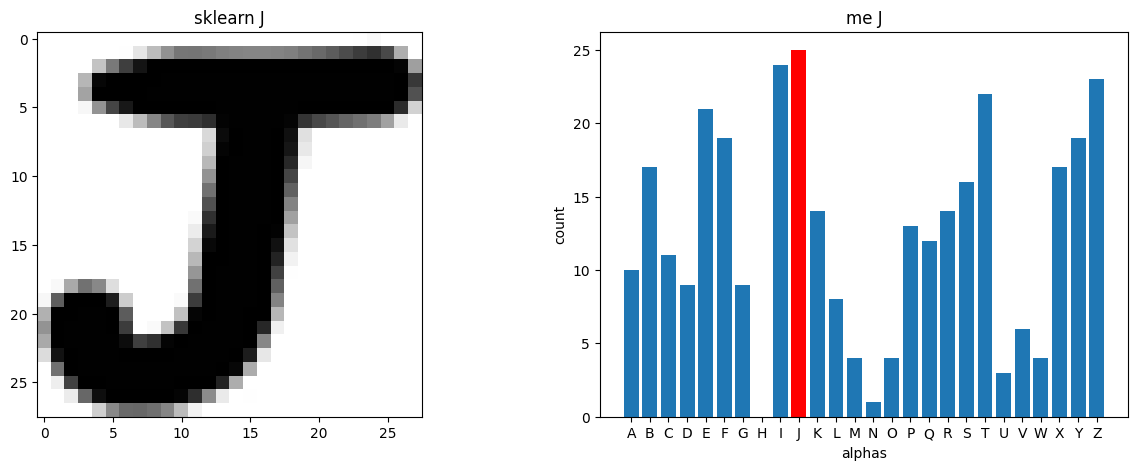

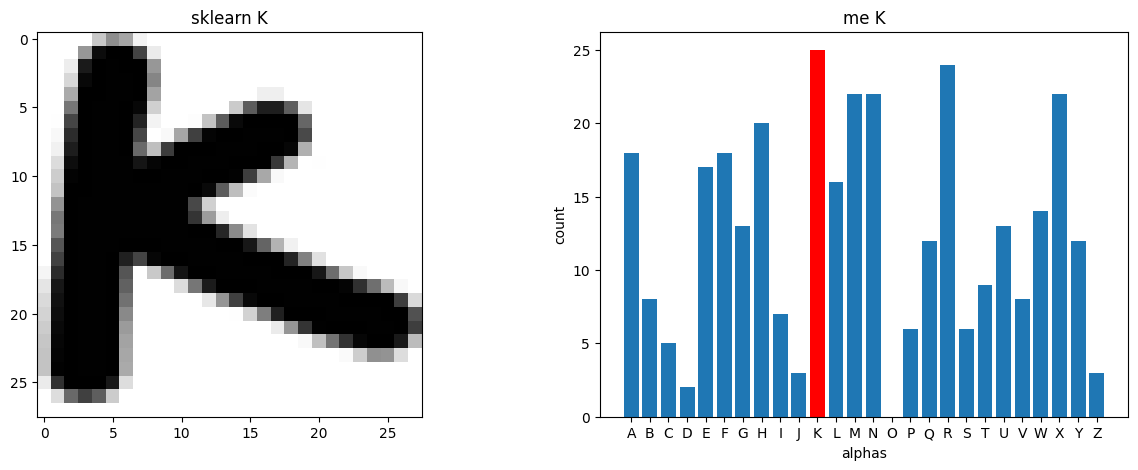

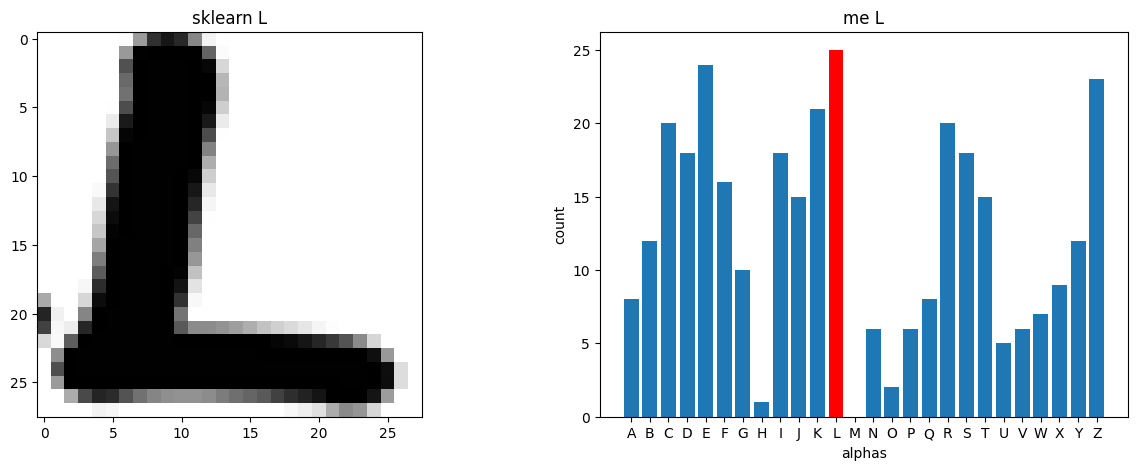

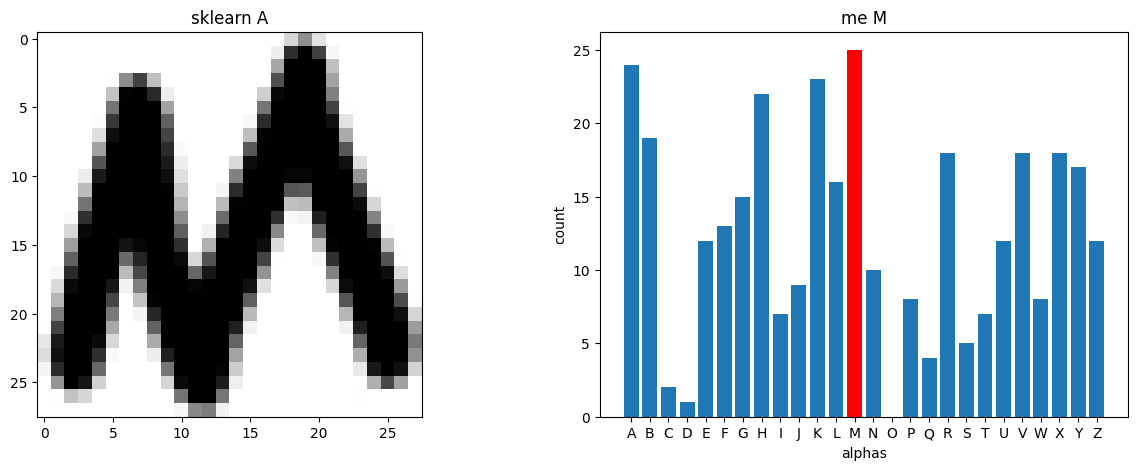

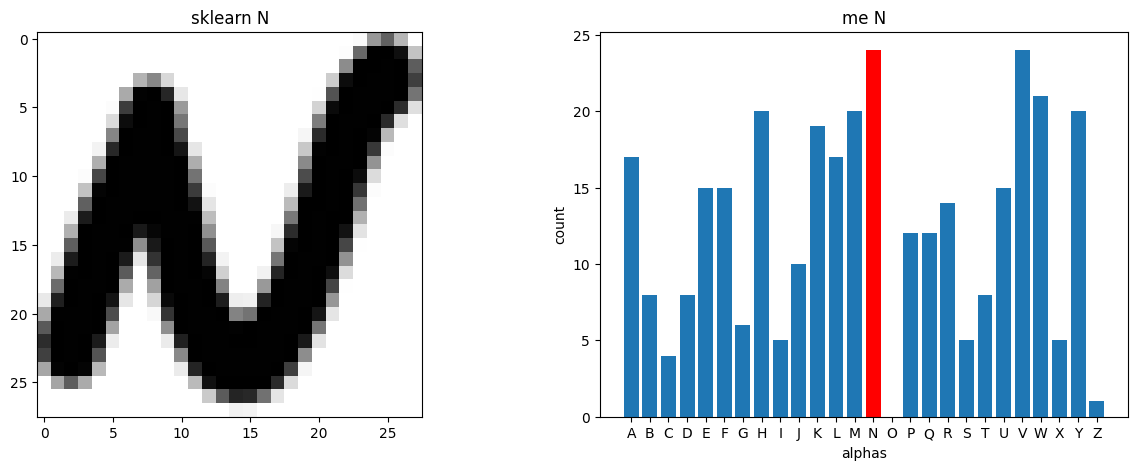

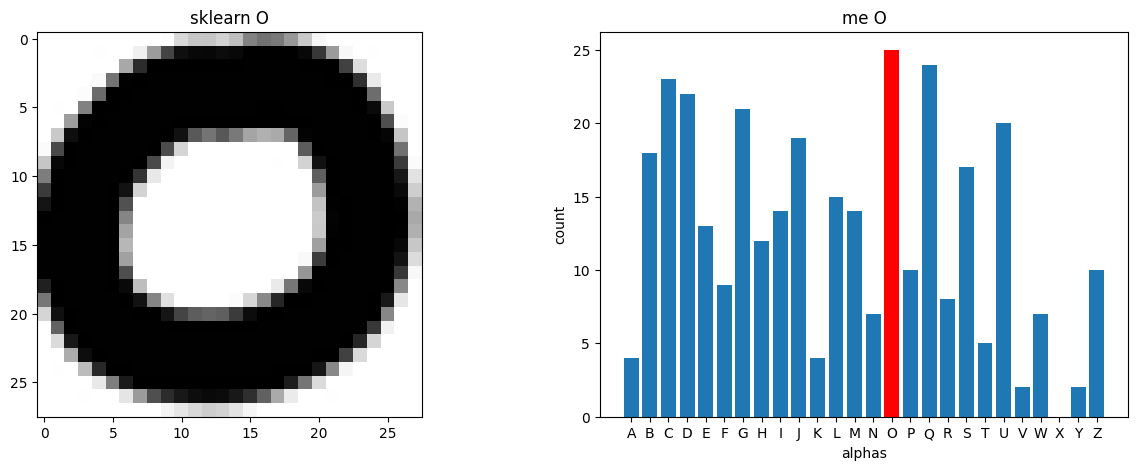

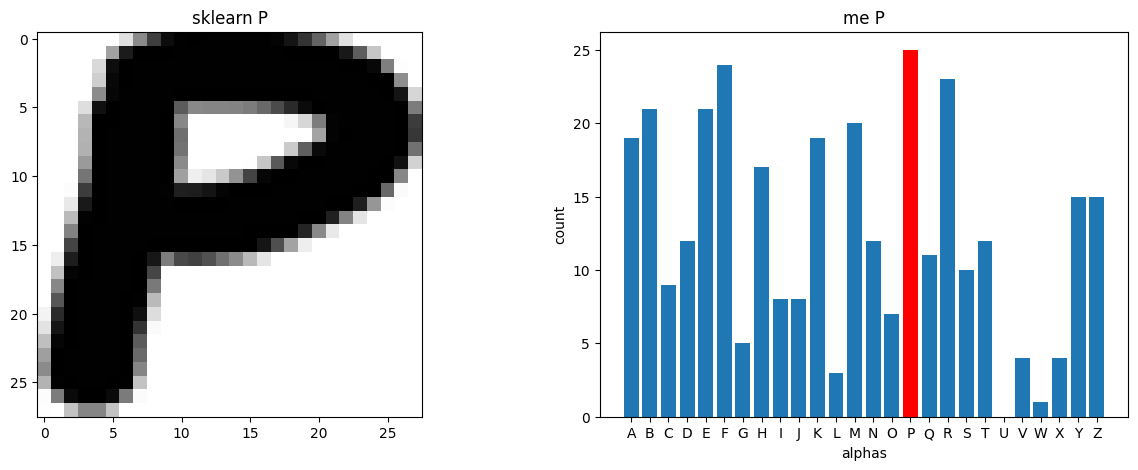

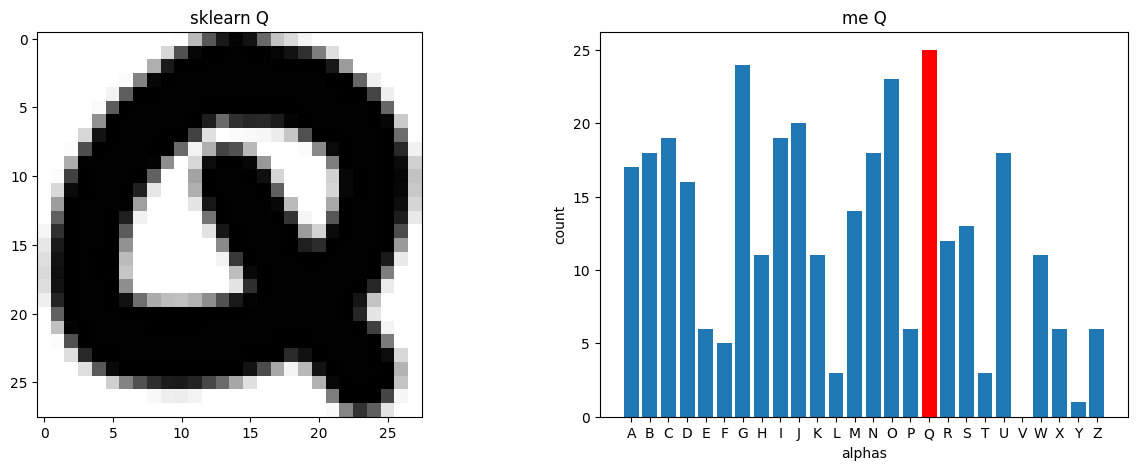

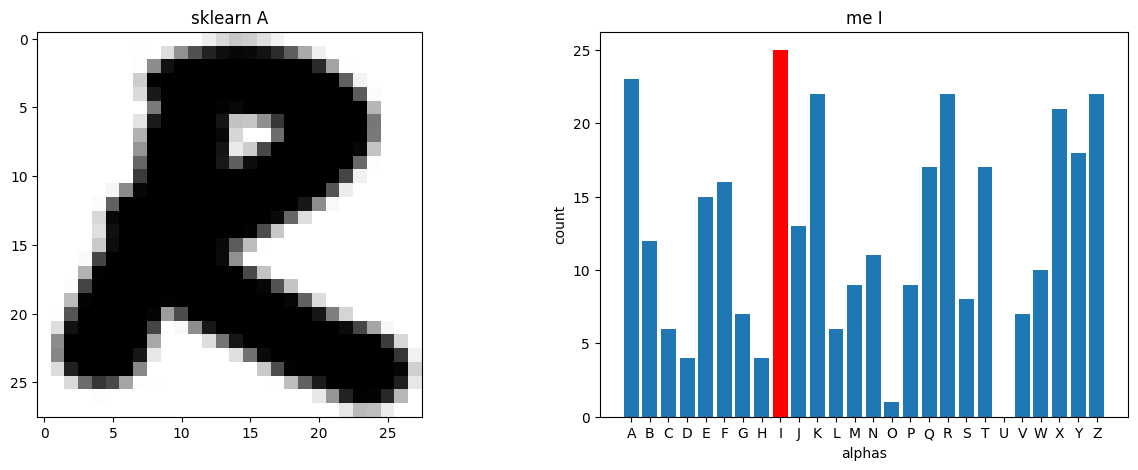

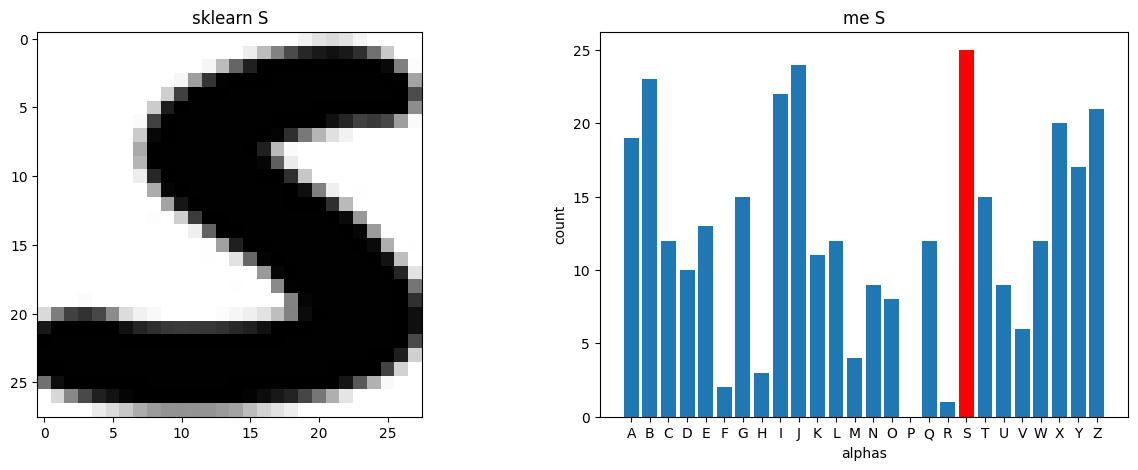

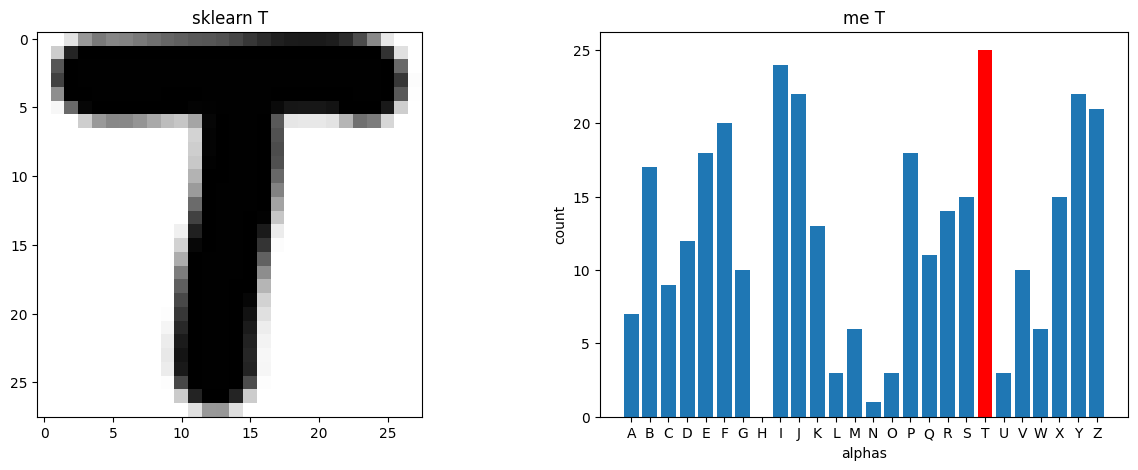

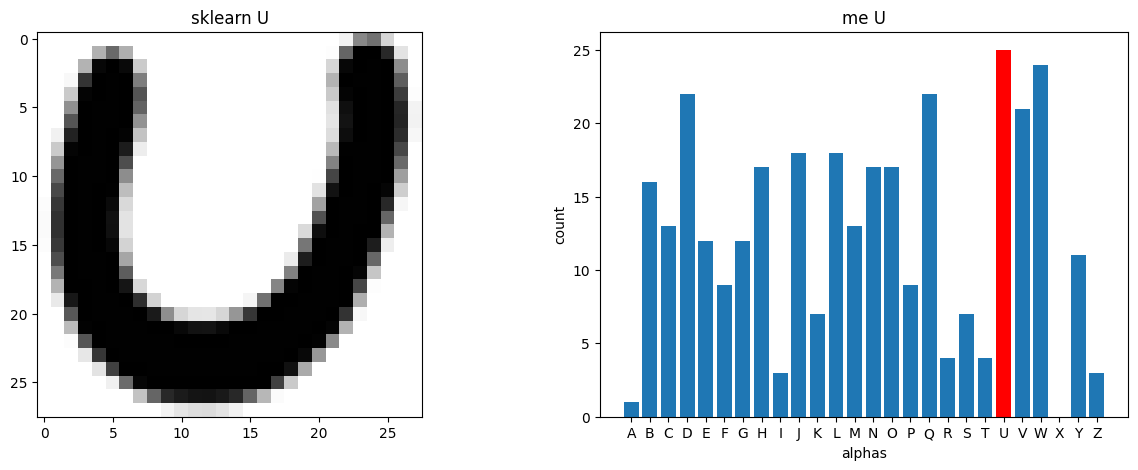

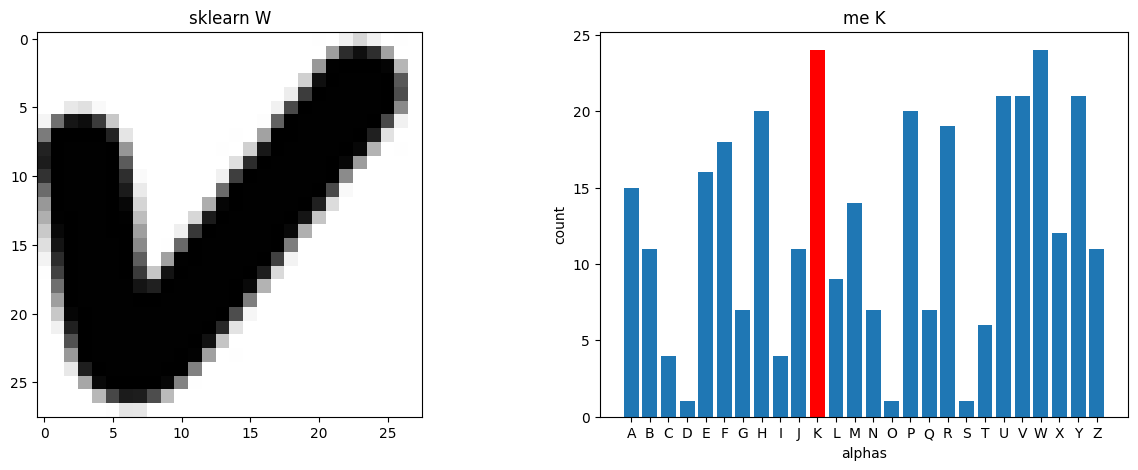

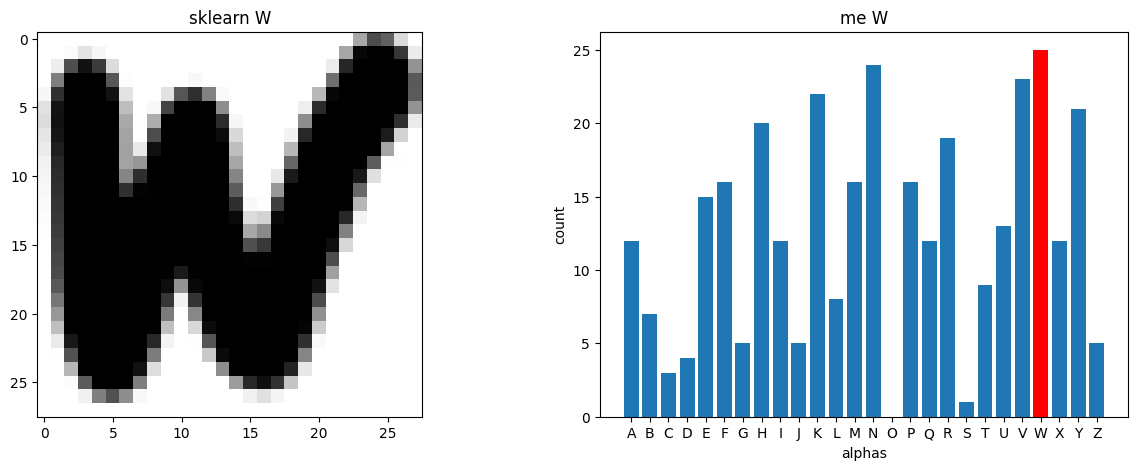

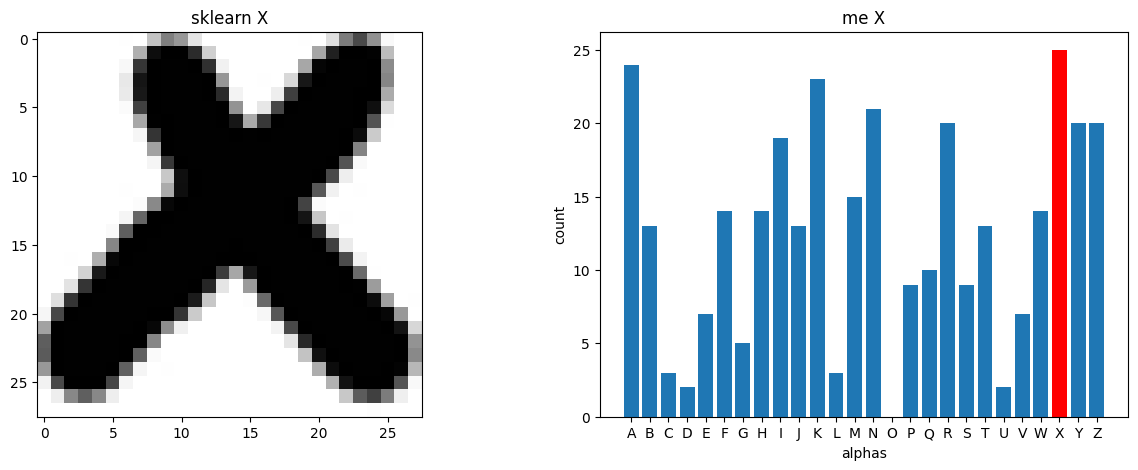

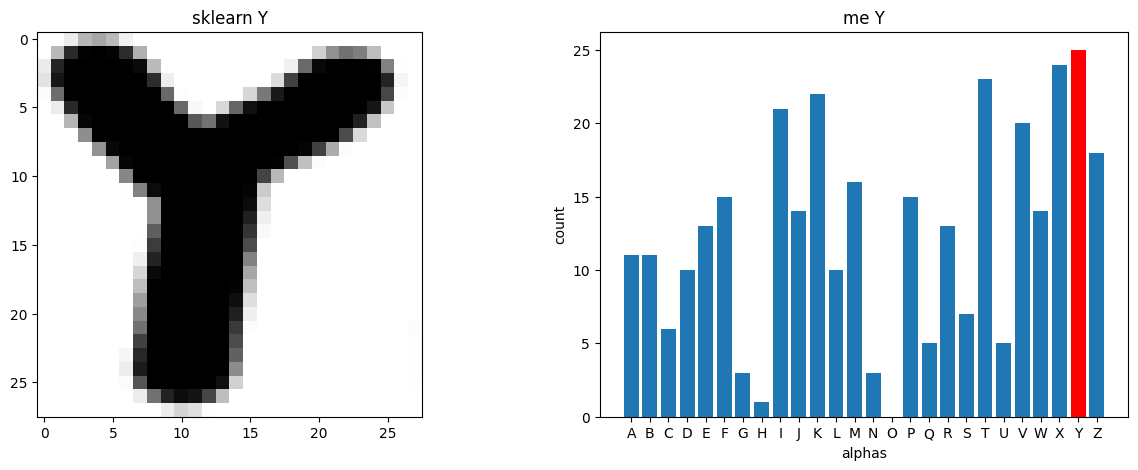

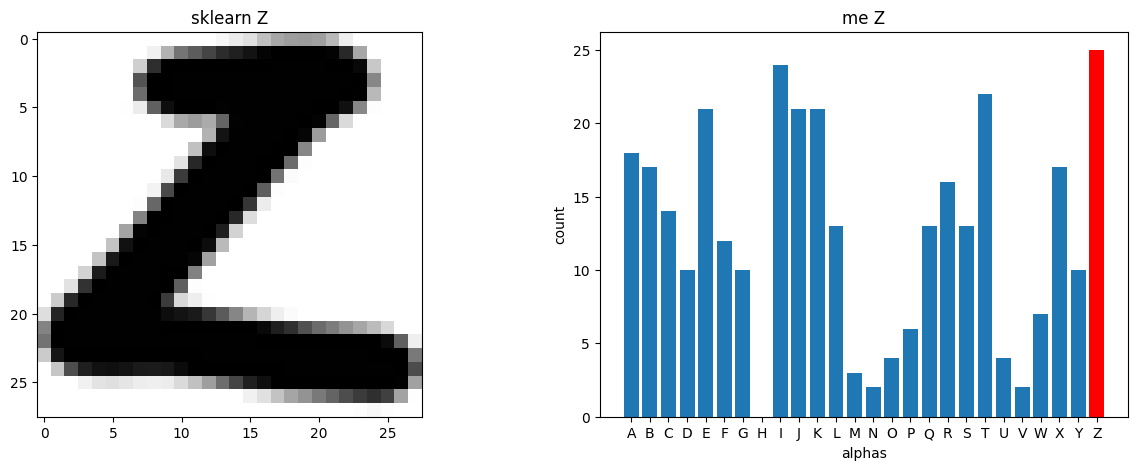

In [59]:
sk_rate = 0
my_rate = 0
same = 0
for i in alphas:
    P = i
    sk_pre, my_pred = apply(P)
    if sk_pre == i:
        sk_rate += 1
    if my_pred == i:
        my_rate += 1
    if sk_pre == my_pred:
        same += 1
    plt.show()

In [60]:
print("sklearn准确率：",sk_rate/len(alphas))
print("我准确率：",my_rate/len(alphas))
print("我与sklearn预测相同率：",same/len(alphas))

sklearn准确率： 0.8846153846153846
我准确率： 0.9230769230769231
我与sklearn预测相同率： 0.8846153846153846
